<a href="https://colab.research.google.com/github/josefinalin92/association-rules/blob/main/Deep%20Learning/Taller%20de%20DL/Tareas/Tarea_1-letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Letra de Tarea

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

# Librerías

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive/Master/ML para AI/Taller Deep Learning/')

In [3]:
!pip install torchinfo

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import Imagenette
from torchvision.datasets import ImageNet


from torchinfo import summary

import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from utils import (
    train,
    model_calassification_report,
    show_tensor_image,
    show_tensor_images,
)

In [5]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [7]:
BATCH_SIZE = 2048  # tamaño del batch

# Carga de datos

In [8]:
datasets.Imagenette

torchvision.datasets.imagenette.Imagenette

In [ ]:
# Descarga del dataset Imagenette
# Definimos transformaciones mínimas para análisis (sin normalización para preservar valores originales)
minimal_transform = T.Compose([
    T.ToImage(),  # Solo convertimos a tensor, sin normalización ni redimensionamiento
])

# Creamos el directorio para los datos si no existe
data_dir = Path('./data')
data_dir.mkdir(exist_ok=True)

print("Descargando dataset Imagenette...")

# Descargamos todo el dataset (train + val) para hacer análisis completo
full_train_dataset = Imagenette(
    root=data_dir,
    split='train',
    size='160px',  # Versión más pequeña para empezar (puede cambiar a '320px' o 'full' si prefiere)
    download=True,
    transform=minimal_transform
)

full_val_dataset = Imagenette(
    root=data_dir,
    split='val',
    size='160px',
    download=True,
    transform=minimal_transform
)

print(f"Número de muestras de entrenamiento: {len(full_train_dataset)}")
print(f"Número de muestras de validación: {len(full_val_dataset)}")
print(f"Total de muestras: {len(full_train_dataset) + len(full_val_dataset)}")
print(f"Número de clases: {len(full_train_dataset.classes)}")
print(f"Clases: {full_train_dataset.classes}")

# Combinamos los datasets para análisis completo
from torch.utils.data import ConcatDataset
complete_dataset = ConcatDataset([full_train_dataset, full_val_dataset])
print(f"Dataset completo creado con {len(complete_dataset)} muestras para análisis")


Descargando dataset Imagenette...
Número de muestras de entrenamiento: 9469
Número de muestras de validación: 3925
Total de muestras: 13394
Número de clases: 10
Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]
Dataset completo creado con 13394 muestras para análisis


# Exploración

In [ ]:
# Análisis de distribución de clases

# Función para contar muestras por clase en un dataset
def count_samples_per_class(dataset):
    class_counts = {}
    for _, label in dataset:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

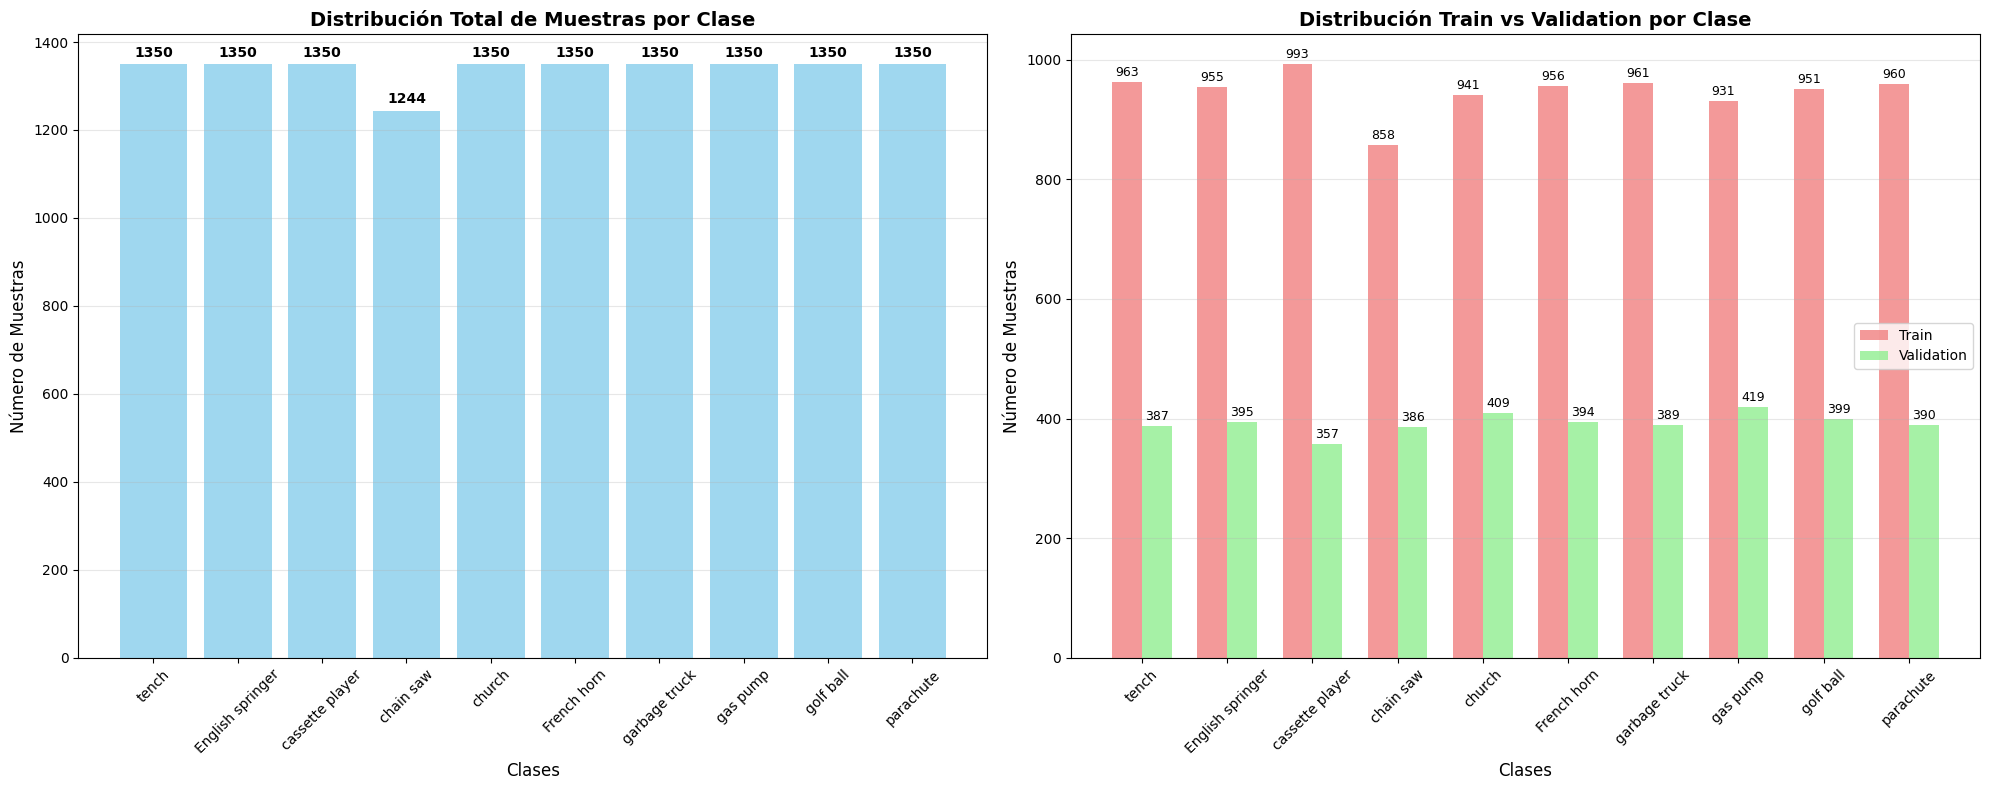

ANÁLISIS DE DISTRIBUCIÓN DE CLASES
Total de muestras: 13394
Número de clases: 10
Promedio de muestras por clase: 1339.4
Clase con más muestras: tench (1350 muestras)
Clase con menos muestras: chain saw (1244 muestras)
Diferencia entre max y min: 106 muestras


In [ ]:
# Contamos las muestras por clase en cada split
train_class_counts = count_samples_per_class(full_train_dataset)
val_class_counts = count_samples_per_class(full_val_dataset)

# Obtenemos los nombres de las clases
class_names = [class_info[0] for class_info in full_train_dataset.classes]
class_indices = list(range(len(class_names)))

# Organizamos los datos para el gráfico
train_counts = [train_class_counts.get(i, 0) for i in class_indices]
val_counts = [val_class_counts.get(i, 0) for i in class_indices]
total_counts = [train_counts[i] + val_counts[i] for i in class_indices]

# Creamos el gráfico de barras
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Gráfico 1: Distribución total por clase
bars1 = ax1.bar(class_names, total_counts, color='skyblue', alpha=0.8)
ax1.set_title('Distribución Total de Muestras por Clase', fontsize=14, fontweight='bold')
ax1.set_xlabel('Clases', fontsize=12)
ax1.set_ylabel('Número de Muestras', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Añadimos los valores encima de cada barra
for bar, count in zip(bars1, total_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{count}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Comparación Train vs Validation
x = range(len(class_names))
width = 0.35

bars2 = ax2.bar([i - width/2 for i in x], train_counts, width,
                label='Train', color='lightcoral', alpha=0.8)
bars3 = ax2.bar([i + width/2 for i in x], val_counts, width,
                label='Validation', color='lightgreen', alpha=0.8)

ax2.set_title('Distribución Train vs Validation por Clase', fontsize=14, fontweight='bold')
ax2.set_xlabel('Clases', fontsize=12)
ax2.set_ylabel('Número de Muestras', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(class_names, rotation=45)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Añadimos los valores encima de cada barra
for bar, count in zip(bars2, train_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}', ha='center', va='bottom', fontsize=9)

for bar, count in zip(bars3, val_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Análisis estadístico
print("=" * 60)
print("ANÁLISIS DE DISTRIBUCIÓN DE CLASES")
print("=" * 60)

print(f"Total de muestras: {sum(total_counts)}")
print(f"Número de clases: {len(class_names)}")
print(f"Promedio de muestras por clase: {sum(total_counts)/len(class_names):.1f}")
print(f"Clase con más muestras: {class_names[total_counts.index(max(total_counts))]} ({max(total_counts)} muestras)")
print(f"Clase con menos muestras: {class_names[total_counts.index(min(total_counts))]} ({min(total_counts)} muestras)")
print(f"Diferencia entre max y min: {max(total_counts) - min(total_counts)} muestras")



Clases con distribución distinta, se podría:
* Generar nuevos datos girando imagenes originales
* Aumentar cantidad de muestra de Train hasta tener igual cantidad de imagenes en todas las clases

In [ ]:

print("\nDETALLE POR CLASE:")
print("-" * 60)
for i, class_name in enumerate(class_names):
    print(f"{class_name:20} | Train: {train_counts[i]:4d} | Val: {val_counts[i]:4d} | Total: {total_counts[i]:4d}")

# Evaluamos el balanceo del dataset
import numpy as np
std_dev = np.std(total_counts)
mean_count = np.mean(total_counts)
cv = std_dev / mean_count  # Coeficiente de variación

print(f"\nEVALUACIÓN DEL BALANCEO:")
print("-" * 60)
print(f"Desviación estándar: {std_dev:.2f}")
print(f"Coeficiente de variación: {cv:.3f}")
if cv < 0.1:
    print("✅ Dataset MUY BALANCEADO (CV < 0.1)")
elif cv < 0.2:
    print("✅ Dataset BALANCEADO (CV < 0.2)")
elif cv < 0.3:
    print("⚠️  Dataset MODERADAMENTE DESBALANCEADO (CV < 0.3)")
else:
    print("❌ Dataset DESBALANCEADO (CV >= 0.3)")


DETALLE POR CLASE:
------------------------------------------------------------
tench                | Train:  963 | Val:  387 | Total: 1350
English springer     | Train:  955 | Val:  395 | Total: 1350
cassette player      | Train:  993 | Val:  357 | Total: 1350
chain saw            | Train:  858 | Val:  386 | Total: 1244
church               | Train:  941 | Val:  409 | Total: 1350
French horn          | Train:  956 | Val:  394 | Total: 1350
garbage truck        | Train:  961 | Val:  389 | Total: 1350
gas pump             | Train:  931 | Val:  419 | Total: 1350
golf ball            | Train:  951 | Val:  399 | Total: 1350
parachute            | Train:  960 | Val:  390 | Total: 1350

EVALUACIÓN DEL BALANCEO:
------------------------------------------------------------
Desviación estándar: 31.80
Coeficiente de variación: 0.024
✅ Dataset MUY BALANCEADO (CV < 0.1)


Otros elementos que se pueden analizar:
* Calidad de imagenes
* Cantidad de colores en los canales RGB

In [ ]:
# Análisis de Calidad de Imágenes y Canales RGB

from collections import Counter
import seaborn as sns

def analyze_image_quality_and_colors(dataset, sample_size=1000):
    """
    Analiza la calidad de las imágenes y distribución de colores RGB
    """
    print("Analizando calidad de imágenes y colores RGB...")
    print("=" * 60)

    # Listas para almacenar estadísticas
    dimensions = []
    resolutions = []
    aspect_ratios = []
    rgb_stats = {'red': [], 'green': [], 'blue': []}
    unique_colors_per_image = []
    brightness_levels = []
    contrast_levels = []

    # Tomamos una muestra del dataset para análisis
    sample_indices = np.random.choice(len(dataset), min(sample_size, len(dataset)), replace=False)

    for i, idx in enumerate(sample_indices):
        if i % 200 == 0:
            print(f"Procesando imagen {i+1}/{len(sample_indices)}...")

        image, _ = dataset[idx]

        # Convertimos a numpy array si es tensor
        if hasattr(image, 'numpy'):
            img_array = image.numpy()
        else:
            img_array = np.array(image)

        # Aseguramos que esté en formato (H, W, C)
        if img_array.shape[0] == 3:  # Si está en formato (C, H, W)
            img_array = np.transpose(img_array, (1, 2, 0))

        # Información básica de la imagen
        height, width, channels = img_array.shape
        dimensions.append((height, width))
        resolutions.append(height * width)
        aspect_ratios.append(width / height)

        # Análisis de canales RGB (normalizamos a 0-255 si es necesario)
        if img_array.max() <= 1.0:
            img_array = (img_array * 255).astype(np.uint8)

        # Estadísticas por canal
        rgb_stats['red'].append({
            'mean': np.mean(img_array[:, :, 0]),
            'std': np.std(img_array[:, :, 0]),
            'min': np.min(img_array[:, :, 0]),
            'max': np.max(img_array[:, :, 0])
        })

        rgb_stats['green'].append({
            'mean': np.mean(img_array[:, :, 1]),
            'std': np.std(img_array[:, :, 1]),
            'min': np.min(img_array[:, :, 1]),
            'max': np.max(img_array[:, :, 1])
        })

        rgb_stats['blue'].append({
            'mean': np.mean(img_array[:, :, 2]),
            'std': np.std(img_array[:, :, 2]),
            'min': np.min(img_array[:, :, 2]),
            'max': np.max(img_array[:, :, 2])
        })

        # Cantidad de colores únicos
        img_flat = img_array.reshape(-1, 3)
        unique_colors = len(np.unique(img_flat.view(np.dtype((np.void, img_flat.dtype.itemsize * 3)))))
        unique_colors_per_image.append(unique_colors)

        # Brightness (promedio de todos los píxeles)
        brightness = np.mean(img_array)
        brightness_levels.append(brightness)

        # Contrast (desviación estándar)
        contrast = np.std(img_array)
        contrast_levels.append(contrast)

    return {
        'dimensions': dimensions,
        'resolutions': resolutions,
        'aspect_ratios': aspect_ratios,
        'rgb_stats': rgb_stats,
        'unique_colors': unique_colors_per_image,
        'brightness': brightness_levels,
        'contrast': contrast_levels
    }


Analizando calidad de imágenes y colores RGB...
Procesando imagen 1/1000...
Procesando imagen 201/1000...
Procesando imagen 401/1000...
Procesando imagen 601/1000...
Procesando imagen 801/1000...


/tmp/ipython-input-2805408469.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2, 0].boxplot(rgb_data, labels=['Red', 'Green', 'Blue'])


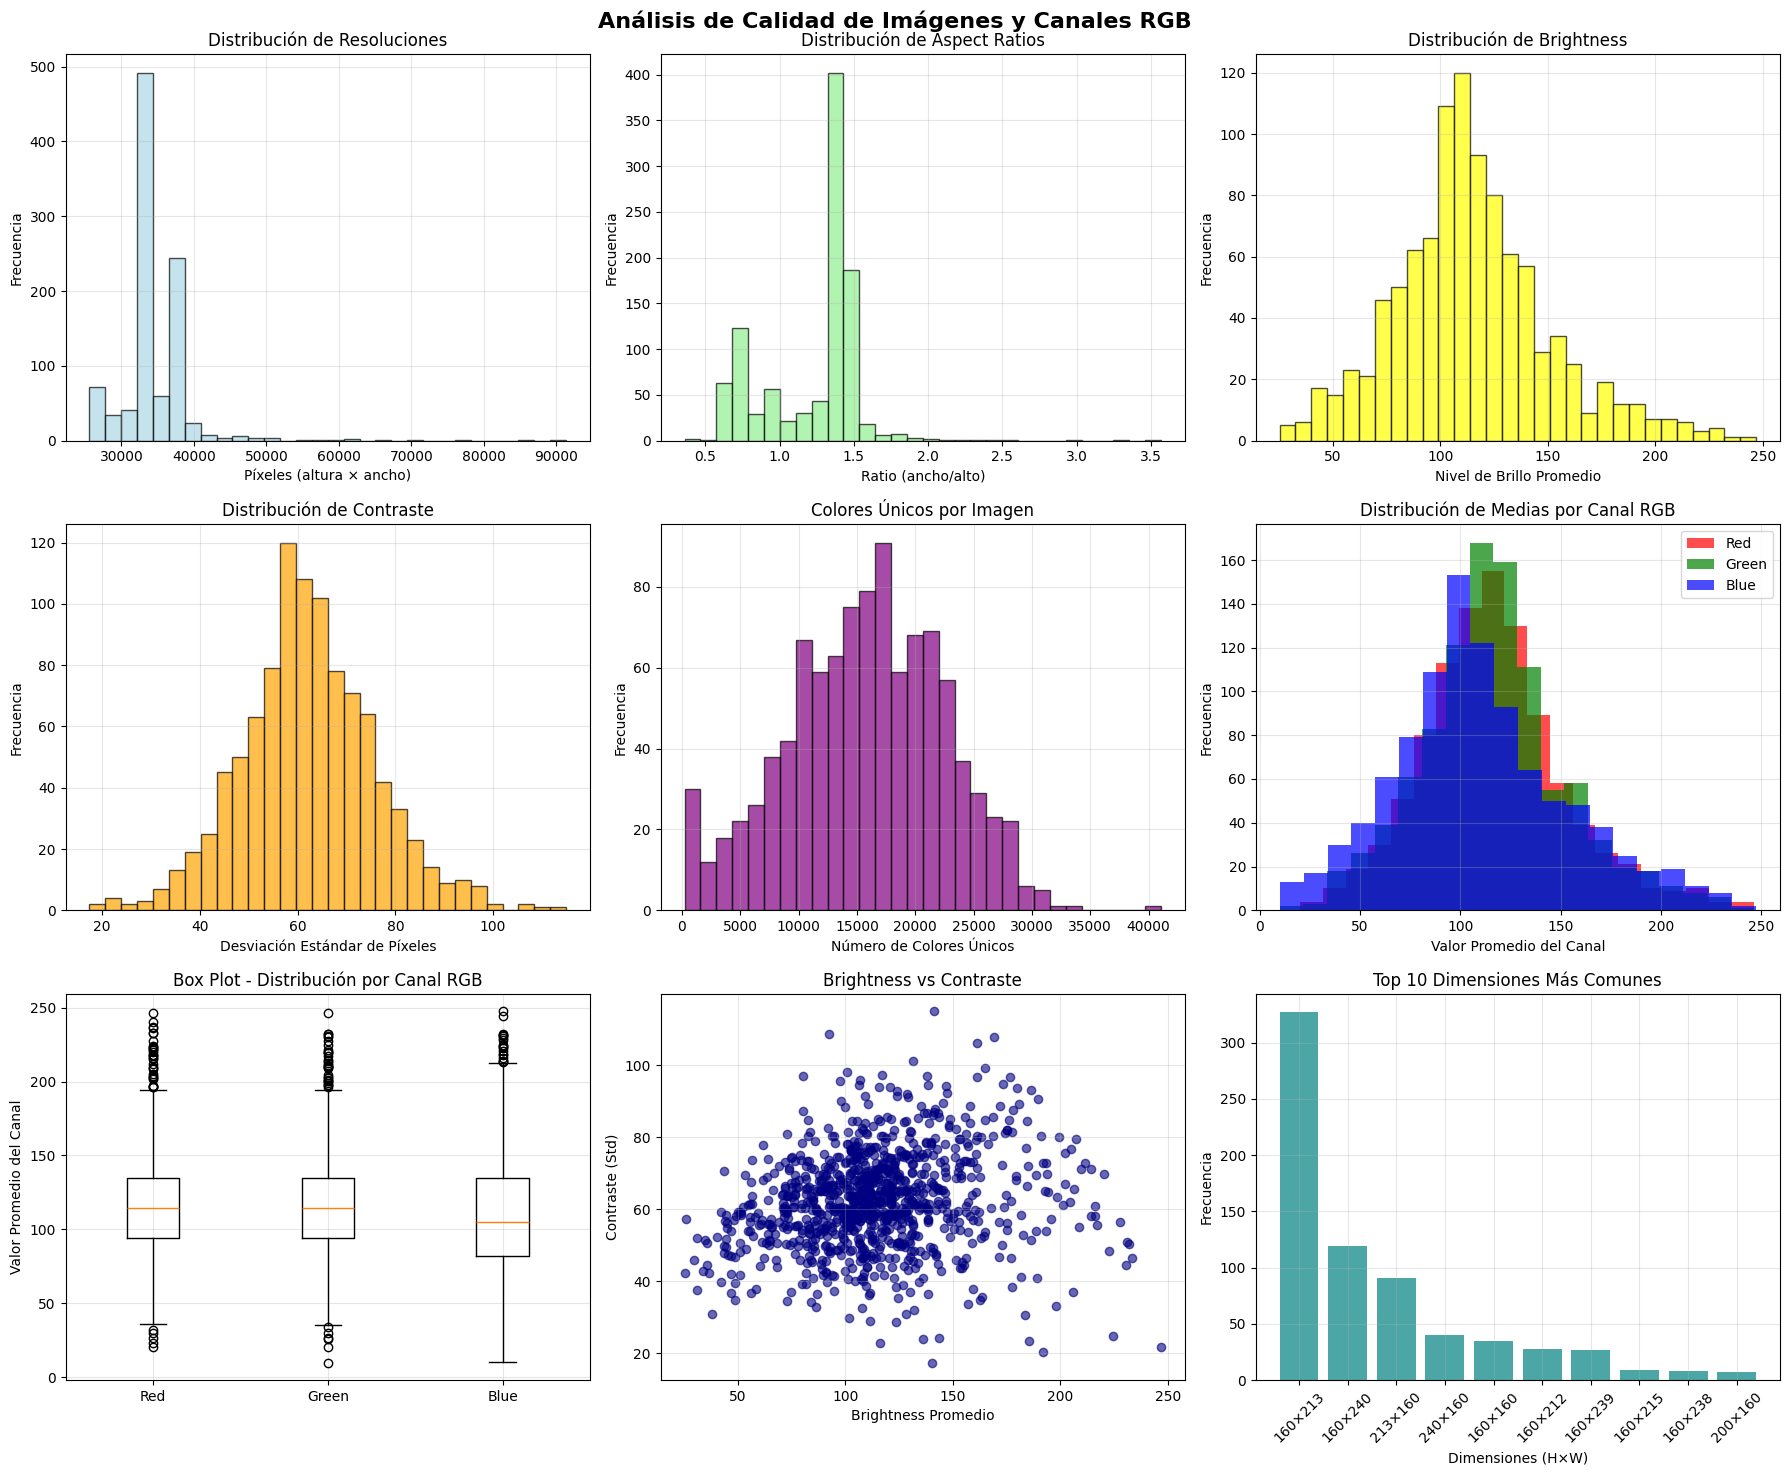

In [ ]:
# Realizamos el análisis
analysis_results = analyze_image_quality_and_colors(complete_dataset, sample_size=1000)

# Visualizaciones
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Análisis de Calidad de Imágenes y Canales RGB', fontsize=16, fontweight='bold')

# 1. Distribución de resoluciones
axes[0, 0].hist(analysis_results['resolutions'], bins=30, color='lightblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribución de Resoluciones')
axes[0, 0].set_xlabel('Píxeles (altura × ancho)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(alpha=0.3)

# 2. Distribución de aspect ratios
axes[0, 1].hist(analysis_results['aspect_ratios'], bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribución de Aspect Ratios')
axes[0, 1].set_xlabel('Ratio (ancho/alto)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(alpha=0.3)

# 3. Distribución de brightness
axes[0, 2].hist(analysis_results['brightness'], bins=30, color='yellow', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Distribución de Brightness')
axes[0, 2].set_xlabel('Nivel de Brillo Promedio')
axes[0, 2].set_ylabel('Frecuencia')
axes[0, 2].grid(alpha=0.3)

# 4. Distribución de contrast
axes[1, 0].hist(analysis_results['contrast'], bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribución de Contraste')
axes[1, 0].set_xlabel('Desviación Estándar de Píxeles')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].grid(alpha=0.3)

# 5. Colores únicos por imagen
axes[1, 1].hist(analysis_results['unique_colors'], bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Colores Únicos por Imagen')
axes[1, 1].set_xlabel('Número de Colores Únicos')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].grid(alpha=0.3)

# 6. Comparación de canales RGB (medias)
red_means = [stat['mean'] for stat in analysis_results['rgb_stats']['red']]
green_means = [stat['mean'] for stat in analysis_results['rgb_stats']['green']]
blue_means = [stat['mean'] for stat in analysis_results['rgb_stats']['blue']]

axes[1, 2].hist(red_means, bins=20, alpha=0.7, label='Red', color='red')
axes[1, 2].hist(green_means, bins=20, alpha=0.7, label='Green', color='green')
axes[1, 2].hist(blue_means, bins=20, alpha=0.7, label='Blue', color='blue')
axes[1, 2].set_title('Distribución de Medias por Canal RGB')
axes[1, 2].set_xlabel('Valor Promedio del Canal')
axes[1, 2].set_ylabel('Frecuencia')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

# 7. Box plot de canales RGB
rgb_data = [red_means, green_means, blue_means]
axes[2, 0].boxplot(rgb_data, labels=['Red', 'Green', 'Blue'])
axes[2, 0].set_title('Box Plot - Distribución por Canal RGB')
axes[2, 0].set_ylabel('Valor Promedio del Canal')
axes[2, 0].grid(alpha=0.3)

# 8. Scatter plot: Brightness vs Contrast
axes[2, 1].scatter(analysis_results['brightness'], analysis_results['contrast'], alpha=0.6, color='navy')
axes[2, 1].set_title('Brightness vs Contraste')
axes[2, 1].set_xlabel('Brightness Promedio')
axes[2, 1].set_ylabel('Contraste (Std)')
axes[2, 1].grid(alpha=0.3)

# 9. Dimensiones más comunes
dimension_counts = Counter(analysis_results['dimensions'])
top_dims = dimension_counts.most_common(10)
dim_labels = [f"{d[0]}×{d[1]}" for d, _ in top_dims]
dim_counts = [count for _, count in top_dims]

axes[2, 2].bar(range(len(dim_labels)), dim_counts, color='teal', alpha=0.7)
axes[2, 2].set_title('Top 10 Dimensiones Más Comunes')
axes[2, 2].set_xlabel('Dimensiones (H×W)')
axes[2, 2].set_ylabel('Frecuencia')
axes[2, 2].set_xticks(range(len(dim_labels)))
axes[2, 2].set_xticklabels(dim_labels, rotation=45)
axes[2, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [ ]:
# Estadísticas detalladas
print("\n" + "=" * 80)
print("ESTADÍSTICAS DETALLADAS DE CALIDAD DE IMAGEN")
print("=" * 80)

print(f"\n📐 DIMENSIONES Y RESOLUCIÓN:")
print(f"   • Resolución promedio: {np.mean(analysis_results['resolutions']):.0f} píxeles")
print(f"   • Resolución mínima: {np.min(analysis_results['resolutions'])} píxeles")
print(f"   • Resolución máxima: {np.max(analysis_results['resolutions'])} píxeles")
unique_dims = len(set(analysis_results['dimensions']))
print(f"   • Dimensiones únicas encontradas: {unique_dims}")
most_common_dim = dimension_counts.most_common(1)[0]
print(f"   • Dimensión más común: {most_common_dim[0][0]}×{most_common_dim[0][1]} ({most_common_dim[1]} imágenes)")

print(f"\n📏 ASPECT RATIOS:")
print(f"   • Aspect ratio promedio: {np.mean(analysis_results['aspect_ratios']):.3f}")
print(f"   • Aspect ratio mín/máx: {np.min(analysis_results['aspect_ratios']):.3f} / {np.max(analysis_results['aspect_ratios']):.3f}")
square_images = sum(1 for ar in analysis_results['aspect_ratios'] if 0.95 <= ar <= 1.05)
print(f"   • Imágenes aproximadamente cuadradas: {square_images} ({square_images/len(analysis_results['aspect_ratios'])*100:.1f}%)")

print(f"\n💡 CALIDAD DE IMAGEN:")
print(f"   • Brightness promedio: {np.mean(analysis_results['brightness']):.1f}")
print(f"   • Contraste promedio: {np.mean(analysis_results['contrast']):.1f}")
print(f"   • Colores únicos promedio por imagen: {np.mean(analysis_results['unique_colors']):.0f}")
print(f"   • Rango de colores únicos: {np.min(analysis_results['unique_colors'])} - {np.max(analysis_results['unique_colors'])}")

print(f"\n🎨 ANÁLISIS DE CANALES RGB:")
for channel, color in [('red', '🔴'), ('green', '🟢'), ('blue', '🔵')]:
    means = [stat['mean'] for stat in analysis_results['rgb_stats'][channel]]
    stds = [stat['std'] for stat in analysis_results['rgb_stats'][channel]]
    print(f"   {color} Canal {channel.upper()}:")
    print(f"      - Media global: {np.mean(means):.1f} ± {np.std(means):.1f}")
    print(f"      - Variabilidad promedio: {np.mean(stds):.1f}")




ESTADÍSTICAS DETALLADAS DE CALIDAD DE IMAGEN

📐 DIMENSIONES Y RESOLUCIÓN:
   • Resolución promedio: 35016 píxeles
   • Resolución mínima: 25600 píxeles
   • Resolución máxima: 91360 píxeles
   • Dimensiones únicas encontradas: 167
   • Dimensión más común: 160×213 (327 imágenes)

📏 ASPECT RATIOS:
   • Aspect ratio promedio: 1.223
   • Aspect ratio mín/máx: 0.360 / 3.569
   • Imágenes aproximadamente cuadradas: 62 (6.2%)

💡 CALIDAD DE IMAGEN:
   • Brightness promedio: 114.3
   • Contraste promedio: 62.3
   • Colores únicos promedio por imagen: 15716
   • Rango de colores únicos: 224 - 41074

🎨 ANÁLISIS DE CANALES RGB:
   🔴 Canal RED:
      - Media global: 116.6 ± 35.7
      - Variabilidad promedio: 60.1
   🟢 Canal GREEN:
      - Media global: 116.2 ± 36.4
      - Variabilidad promedio: 58.4
   🔵 Canal BLUE:
      - Media global: 110.1 ± 43.5
      - Variabilidad promedio: 61.1


In [ ]:
# Recomendaciones basadas en el análisis
print(f"\n💡 RECOMENDACIONES PARA PREPROCESAMIENTO:")
print("=" * 80)

if unique_dims > 5:
    print("✅ Recomendación: REDIMENSIONAR a tamaño fijo (ej: 224×224) - Alta variabilidad de dimensiones")
else:
    print("ℹ️  Dimensiones relativamente consistentes, redimensionamiento opcional")

avg_brightness = np.mean(analysis_results['brightness'])
if avg_brightness < 85:
    print("✅ Recomendación: AJUSTE DE BRIGHTNESS - Imágenes tienden a ser oscuras")
elif avg_brightness > 170:
    print("✅ Recomendación: AJUSTE DE BRIGHTNESS - Imágenes tienden a ser muy claras")
else:
    print("ℹ️  Brightness balanceado, ajustes opcionales")

avg_contrast = np.mean(analysis_results['contrast'])
if avg_contrast < 30:
    print("✅ Recomendación: MEJORA DE CONTRASTE - Bajo contraste detectado")
else:
    print("ℹ️  Contraste adecuado")

channel_balance = [
    np.mean([stat['mean'] for stat in analysis_results['rgb_stats']['red']]),
    np.mean([stat['mean'] for stat in analysis_results['rgb_stats']['green']]),
    np.mean([stat['mean'] for stat in analysis_results['rgb_stats']['blue']])
]
if max(channel_balance) - min(channel_balance) > 20:
    print("✅ Recomendación: NORMALIZACIÓN POR CANAL - Desbalance entre canales RGB detectado")
else:
    print("ℹ️  Canales RGB relativamente balanceados")

avg_colors = np.mean(analysis_results['unique_colors'])
if avg_colors > 50000:
    print("✅ Recomendación: Considerar REDUCCIÓN DE COLORES si hay limitaciones computacionales")
else:
    print("ℹ️  Diversidad de colores adecuada para entrenamiento")


💡 RECOMENDACIONES PARA PREPROCESAMIENTO:
✅ Recomendación: REDIMENSIONAR a tamaño fijo (ej: 224×224) - Alta variabilidad de dimensiones
ℹ️  Brightness balanceado, ajustes opcionales
ℹ️  Contraste adecuado
ℹ️  Canales RGB relativamente balanceados
ℹ️  Diversidad de colores adecuada para entrenamiento


## Redimensionar imagen
¿Cómo determinar la resolción optima para redimensionar todo el dataset?

In [22]:
def rescale_to_1_255(tensor):
    # La transformación a ToTensor() convierte a float32,
    # por lo que hacemos la operación matemática con el factor 254.0
    tensor = (tensor * 254.0) + 1.0

    # Opcional: convertir a tipo de dato entero (uint8) si lo prefieres para 8 bits
    # Descomenta la siguiente línea si necesitas un tensor de enteros
    # tensor = tensor.to(torch.uint8)

    return tensor

In [9]:
data_dir = Path("data")
IMG_SIZE = 224
transforms = T.Compose(
    [
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.Grayscale(num_output_channels=1),
        T.ToTensor(),
        T.Lambda(rescale_to_1_255)
    ]
)


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


NameError: name 'rescale_to_1_255' is not defined

In [ ]:
# Descargamos todo el dataset (train + val) para hacer análisis completo
full_train_dataset = Imagenette(
    root=data_dir,
    split='train',
    size='160px',  # Versión más pequeña para empezar (puede cambiar a '320px' o 'full' si prefiere)
    download=True,
    transform=transforms
)

full_test_dataset = Imagenette(
    root=data_dir,
    split='val',
    size='160px',
    download=True,
    transform=transforms
)

print(f"Número de muestras de entrenamiento: {len(full_train_dataset)}")
print(f"Número de muestras de validación: {len(full_val_dataset)}")
print(f"Total de muestras: {len(full_train_dataset) + len(full_val_dataset)}")
print(f"Número de clases: {len(full_train_dataset.classes)}")
print(f"Clases: {full_train_dataset.classes}")

# Combinamos los datasets para análisis completo
from torch.utils.data import ConcatDataset
complete_dataset = ConcatDataset([full_train_dataset, full_val_dataset])
print(f"Dataset completo creado con {len(complete_dataset)} muestras para análisis")


Número de muestras de entrenamiento: 9469
Número de muestras de validación: 3925
Total de muestras: 13394
Número de clases: 10
Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]
Dataset completo creado con 13394 muestras para análisis


In [ ]:
full_train_dataset[0][0]

tensor([[[107.4703, 142.4088, 176.2028,  ..., 183.3071, 204.7827, 200.1697],
         [126.8208, 163.3409, 189.2725,  ..., 176.6973, 195.5508, 189.3562],
         [156.7497, 175.4464, 183.1637,  ..., 167.7535, 184.4119, 177.2946],
         ...,
         [157.8035, 148.0405, 141.0327,  ..., 176.5431, 141.9651, 118.3727],
         [138.3187, 139.1155, 139.9222,  ..., 161.4112, 118.0813, 102.1436],
         [119.4077, 127.7113, 137.9823,  ..., 135.8698,  98.1803,  96.6664]]])

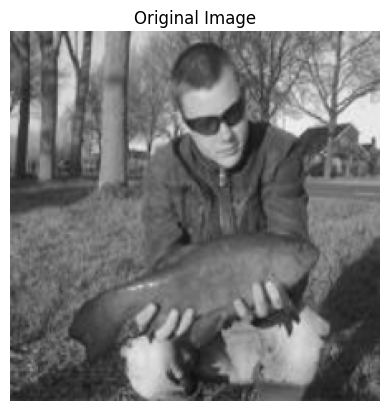

In [ ]:
show_tensor_image(full_train_dataset[9][0], title="Original Image", vmin=0, vmax=255)

## LetNet

In [16]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet, self).__init__()
        # Primera capa convolucional
        self.conv1 = nn.Conv2d(in_channels, out_channels=6, kernel_size=5, padding=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Tercera capa convolucional (ajustada para el tamaño de entrada)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)

        # Calculamos el tamaño después de las convoluciones y pooling
        # Input: 224x224 -> Conv1+Pool: 112x112 -> Conv2+Pool: 54x54 -> Conv3: 50x50
        self.fc1 = nn.Linear(120 * 50 * 50, 84)
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        # Primera capa: Conv + Tanh + Pool
        x = self.pool(F.tanh(self.conv1(x)))  # 224x224 -> 112x112

        # Segunda capa: Conv + Tanh + Pool
        x = self.pool(F.tanh(self.conv2(x)))  # 112x112 -> 54x54

        # Tercera capa: Conv + Tanh
        x = F.tanh(self.conv3(x))  # 54x54 -> 50x50

        # Aplanar y pasar por capas fully connected
        x = x.view(-1, 120 * 50 * 50)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)

        return x



In [17]:
full_train_dataset, full_val_dataset = random_split(
    full_train_dataset, [0.8, 0.2]
)

In [19]:
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = DataLoader(
        full_train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        full_val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        full_test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_dataloaders()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
full_train_dataset[0][1]

8

In [ ]:
LR = 0.001
EPOCHS = 10

letnet_model = LeNet(1, 10).to(DEVICE)

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

_, _ = train(letnet_model,
             optimizer,
             criterion,
             train_loader,
             val_loader,
             DEVICE,
             True,
             5,
             EPOCHS)

Epoch: 001 | Train Loss: 2.98881 | Val Loss: 3.07417
Epoch: 002 | Train Loss: 2.98377 | Val Loss: 2.83007
Epoch: 003 | Train Loss: 2.78225 | Val Loss: 2.71016
Epoch: 004 | Train Loss: 2.64684 | Val Loss: 2.59351
Epoch: 005 | Train Loss: 2.54187 | Val Loss: 2.49574
Epoch: 006 | Train Loss: 2.45113 | Val Loss: 2.41471
Epoch: 007 | Train Loss: 2.38456 | Val Loss: 2.36115
Epoch: 008 | Train Loss: 2.34380 | Val Loss: 2.32933
Epoch: 009 | Train Loss: 2.32110 | Val Loss: 2.31215
Epoch: 010 | Train Loss: 2.31157 | Val Loss: 2.30477


## Data Augmentation

In [28]:
IMG_SIZE = 224
## Data Augmentation Transformations
# Transofrmaciones para Train
train_transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomResizedCrop(156),       # Crop and resize to 224x224
    T.RandomHorizontalFlip(),     # Randomly flip the image horizontally
    # T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Randomly change image properties
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),                   # Convert PIL image to PyTorch tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize tensor image
    T.Lambda(rescale_to_1_255)
])

# Transformaciones para validacion
# no se aplica random augmentations
val_transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(rescale_to_1_255)
])


# IMG_SIZE = 224
# transforms = T.Compose(
#     [
#         T.ToImage(),
#         T.ToDtype(torch.float32, scale=True),
#         T.Resize((IMG_SIZE, IMG_SIZE)),
#         T.Grayscale(num_output_channels=1),
#         T.ToTensor(),
#         T.Lambda(rescale_to_1_255)
#     ]
# )


In [29]:
# Descargamos todo el dataset (train + val) para hacer análisis completo
full_train_dataset = Imagenette(
    root=data_dir,
    split='train',
    size='160px',  # Versión más pequeña para empezar (puede cambiar a '320px' o 'full' si prefiere)
    download=True,
    transform=train_transform
)

full_test_dataset = Imagenette(
    root=data_dir,
    split='val',
    size='160px',
    download=True,
    transform=val_transform
)

In [30]:
full_train_dataset, full_val_dataset = random_split(
    full_train_dataset, [0.8, 0.2]
)

In [31]:
train_loader, val_loader, test_loader = get_dataloaders()

In [ ]:
LR = 0.001
EPOCHS = 10

letnet_model = LeNet(1, 10).to(DEVICE)

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

_, _ = train(letnet_model,
             optimizer,
             criterion,
             train_loader,
             val_loader,
             DEVICE,
             True,
             5,
             EPOCHS)

## DenseNet